# Import Dependencies

In [3]:
import sys
sys.path.append('..')
import dependencies
import soft_dependencies
import matplotlib.pyplot as plt

Python Version 3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]
Numpy Version 1.21.5
Scipy Version 1.7.3
Sklearn Version 1.0.2
Matplotlib Version 3.5.1
Pandas Version 1.4.2
Line Profiler Version 3.3.1
Memory Profiler Version 0.58.0


In [4]:
from Scripts.generate_data import generate_Ys
from Scripts.scBiGLasso import scBiGLasso
from Scripts.anBiGLasso import anBiGLasso
from Scripts.EiGLasso import EiGLasso

In [5]:
# For timing results
import timeit

In [6]:
%load_ext autoreload
%autoreload 2

# Time scBiGLasso and anBiGLasso
**Note:**

'Easy' data comes from precision matrices generated from an
inverse Wishart distribution with many degrees of freedom.
Empirically, scBiGLasso converges very quickly.

'Hard' data comes from precision amtrices generated from an
inverse Wishart distribution with minimal degrees of freedom.
Empirically, scBiGLasso takes a long time to converge.

In [13]:
def generate_timing_graph(
    sizes,
    attempts, 
    m,
    df_scale,
    include_sc=True,
    include_eig=True,
    verbose=False
):
    if include_sc:
        times_sc = []
    times_an = []
    if include_eig:
        times_eig = []
    for size in sizes:
        if verbose:
            print(f"Starting {size=}")
        if include_sc:
            times_sc.append(0)
        times_an.append(0)
        if include_eig:
            times_eig.append(0)
        _, _, Ys = generate_Ys(
            m=m,
            n=(n:=size),
            p=(p:=size),
            expected_nonzero_psi=n**2 / 5,
            expected_nonzero_theta=p**2 / 5,
            structure="Kronecker Sum",
            df_scale=df_scale
        )
        def time_scBiGLasso():
            scBiGLasso(
                N = 100,
                eps = 10e-4,
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01,
                verbose = False
            )
        def time_anBiGLasso():
            anBiGLasso(
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01,
                B_approx_iters = 10
            )
        def time_EiGLasso():
            EiGLasso(
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01
            )
        if include_sc:
            timer = timeit.Timer(time_scBiGLasso)
            times_sc[-1] = timer.timeit(attempts) / attempts
        timer = timeit.Timer(time_anBiGLasso)
        times_an[-1] = timer.timeit(attempts) / attempts
        if include_eig:
            timer = timeit.Timer(time_EiGLasso)
            times_eig[-1] = timer.timeit(attempts) / attempts
        if verbose:
            if include_sc:
                print(
                    f"\tSc: {times_sc[-1]} Seconds"
                    + f"\n\tAn: {times_an[-1]} Seconds"
                    + (f"\n\tEig: {times_eig[-1]} Seconds" if include_eig else "")
                )
            else:
                print(
                    f"\tAn: {times_an[-1]} Seconds"
                    + (f"\n\tEig: {times_eig[-1]} Seconds" if include_eig else "")
                )
    if include_sc and include_eig:
        return times_sc, times_an, times_eig
    elif include_sc:
        return times_sc, times_an
    elif include_eig:
        return times_an, times_eig
    else:
        return times_an

### Large Sample

In [25]:
attempts = 10
print("Times on an 'easy' distribution")
sizes_for_easy = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
sc_easy, an_easy, eig_easy = generate_timing_graph(
    sizes_for_easy,
    attempts,
    df_scale=10,
    m=100,
    verbose=True
)
print("Times on a 'hard' distribution")
sizes_for_hard = [10, 20, 30, 40, 50]
sc_hard, an_hard, eig_hard = generate_timing_graph(
    sizes_for_hard,
    attempts,
    df_scale=1,
    m=100,
    verbose=True
)

Times on an 'easy' distribution
Starting size=10
	Sc: 0.02031685420006397 Seconds
	An: 0.004520549999870127 Seconds
	Eig: 0.027491741600169917 Seconds
Starting size=20
	Sc: 0.03821731659991201 Seconds
	An: 0.008889616699889302 Seconds
	Eig: 0.0036321291998319795 Seconds
Starting size=30
	Sc: 0.05944937910026056 Seconds
	An: 0.014190191599846002 Seconds
	Eig: 0.006035287499980768 Seconds
Starting size=40
	Sc: 0.10161535830011417 Seconds
	An: 0.027215937499931897 Seconds
	Eig: 0.010895404199982296 Seconds
Starting size=50
	Sc: 0.13575163749992497 Seconds
	An: 0.032661725000070876 Seconds
	Eig: 0.018678716599970356 Seconds
Starting size=60
	Sc: 0.1677778125002078 Seconds
	An: 0.03966922079998767 Seconds
	Eig: 0.023214849999931175 Seconds
Starting size=70
	Sc: 0.21178347499990197 Seconds
	An: 0.053237758300019776 Seconds
	Eig: 0.03593200830000569 Seconds
Starting size=80
	Sc: 0.2588437957998394 Seconds
	An: 0.06542632920027244 Seconds
	Eig: 0.0443705666999449 Seconds
Starting size=90
	Sc: 

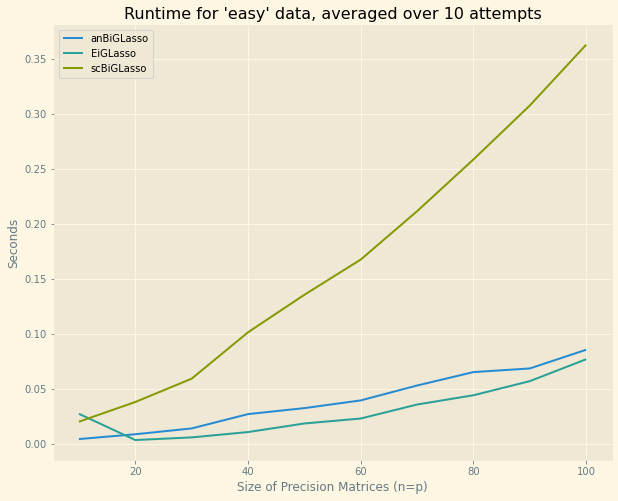

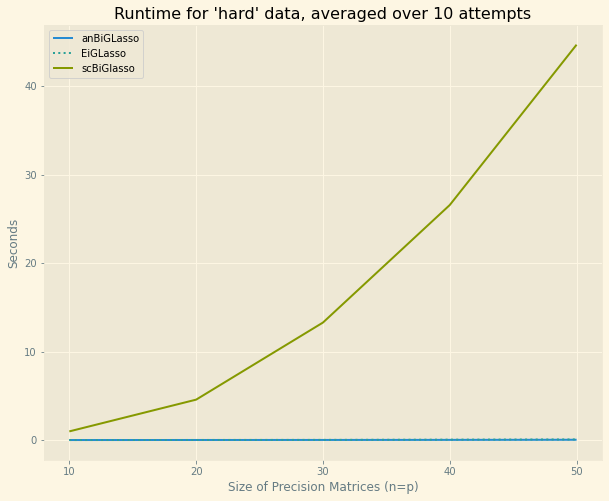

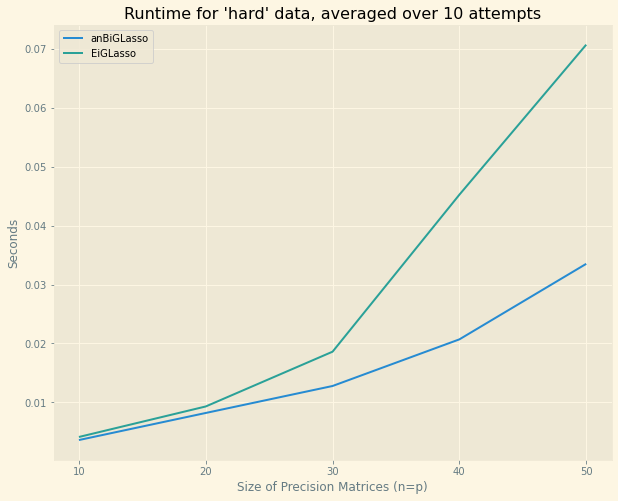

In [27]:
with plt.style.context('Solarize_Light2'):
        fig1, ax1 = plt.subplots(figsize=(10, 8))
        ax1.plot(sizes_for_easy, an_easy, label='anBiGLasso')
        ax1.plot(sizes_for_easy, eig_easy, label='EiGLasso')
        ax1.plot(sizes_for_easy, sc_easy, label='scBiGLasso')
        ax1.set_xlabel("Size of Precision Matrices (n=p)")
        ax1.set_ylabel("Seconds")
        ax1.set_title(f"Runtime for 'easy' data, averaged over {attempts} attempts")
        ax1.legend()
        fig1.savefig(f'../../Plots/Runtimes Comparison/Compare Runtimes Easy Data Large Sample')
        fig2, ax2 = plt.subplots(figsize=(10, 8))
        ax2.plot(sizes_for_hard, an_hard, label='anBiGLasso')
        ax2.plot(sizes_for_hard, eig_hard, label='EiGLasso', linestyle=":")
        ax2.plot(sizes_for_hard, sc_hard, label='scBiGlasso')
        ax2.set_xlabel("Size of Precision Matrices (n=p)")
        ax2.set_ylabel("Seconds")
        ax2.set_xticks([10, 20, 30, 40, 50])
        ax2.set_title(f"Runtime for 'hard' data, averaged over {attempts} attempts")
        ax2.legend()
        fig2.savefig(f'../../Plots/Runtimes Comparison/Compare Runtimes Hard Data Large Sample')
        fig3, ax3 = plt.subplots(figsize=(10, 8))
        ax3.plot(sizes_for_hard, an_hard, label='anBiGLasso')
        ax3.plot(sizes_for_hard, eig_hard, label='EiGLasso')
        ax3.set_xlabel("Size of Precision Matrices (n=p)")
        ax3.set_ylabel("Seconds")
        ax3.set_xticks([10, 20, 30, 40, 50])
        ax3.set_title(f"Runtime for 'hard' data, averaged over {attempts} attempts")
        ax3.legend()
        fig3.savefig(
            f'../../Plots/Runtimes Comparison/Compare Runtimes Hard Data No scBiGLasso Large Sample'
        )

### Small Sample

In [ ]:
print("Times on an 'easy' distribution")
sizes_for_easy = [10, 20, 30, 40, 50]
sc_easy, an_easy, eig_easy = generate_timing_graph(
    sizes_for_easy,
    attempts,
    df_scale=10,
    m=1,
    verbose=True
)
print("Times on a 'hard' distribution")
sizes_for_hard = [10, 20, 30, 40, 50]
sc_hard, an_hard, eig_hard = generate_timing_graph(
    sizes_for_hard,
    attempts,
    df_scale=1,
    m=1,
    verbose=True
)

Times on an 'easy' distribution
Starting size=10
	Sc: 1.2607953083999746 Seconds
	An: 0.0033524415997817415 Seconds
	Eig: 0.01332185829996888 Seconds
Starting size=20
	Sc: 5.971453349999865 Seconds
	An: 0.006494054200084065 Seconds
	Eig: 0.028371866599991337 Seconds
Starting size=30
	Sc: 16.181467150000024 Seconds
	An: 0.01030145420008921 Seconds
	Eig: 0.050427283299723055 Seconds
Starting size=40
	Sc: 27.065335991699975 Seconds
	An: 0.014666941600080464 Seconds
	Eig: 0.09621809579984983 Seconds
Starting size=50
	Sc: 43.165761112499965 Seconds
	An: 0.019178637499862816 Seconds
	Eig: 0.15648142080026445 Seconds
Times on a 'hard' distribution
Starting size=10
	Sc: 0.6306831791000149 Seconds
	An: 0.003476295799919171 Seconds
	Eig: 0.09368250409970642 Seconds
Starting size=20
	Sc: 3.0166078834001384 Seconds
	An: 0.0064133416999538895 Seconds
	Eig: 0.1563388541999302 Seconds
Starting size=30
	Sc: 8.984343512499981 Seconds
	An: 0.010159445899989804 Seconds
	Eig: 1.2047489709002548 Seconds
St

In [ ]:
with plt.style.context('Solarize_Light2'):
        fig1, ax1 = plt.subplots(figsize=(10, 8))
        ax1.plot(sizes_for_easy, an_easy, label='anBiGLasso')
        ax1.plot(sizes_for_easy, eig_easy, label='EiGLasso')
        ax1.plot(sizes_for_easy, sc_easy, label='scBiGLasso')
        ax1.set_xlabel("Size of Precision Matrices (n=p)")
        ax1.set_ylabel("Seconds")
        ax1.set_title(f"Runtime for 'easy' data, averaged over {attempts} attempts")
        ax1.legend()
        fig1.savefig(f'../../Plots/Runtimes Comparison/Compare Runtimes Easy Data Small Sample')
        fig2, ax2 = plt.subplots(figsize=(10, 8))
        ax2.plot(sizes_for_hard, an_hard, label='anBiGLasso')
        ax2.plot(sizes_for_hard, eig_hard, label='EiGLasso', linestyle=":")
        ax2.plot(sizes_for_hard, sc_hard, label='scBiGlasso')
        ax2.set_xlabel("Size of Precision Matrices (n=p)")
        ax2.set_ylabel("Seconds")
        ax2.set_xticks([10, 20, 30, 40, 50])
        ax2.set_title(f"Runtime for 'hard' data, averaged over {attempts} attempts")
        ax2.legend()
        fig2.savefig(f'../../Plots/Runtimes Comparison/Compare Runtimes Hard Data Small Sample')
        fig3, ax3 = plt.subplots(figsize=(10, 8))
        ax3.plot(sizes_for_hard, an_hard, label='anBiGLasso')
        ax3.plot(sizes_for_hard, eig_hard, label='EiGLasso')
        ax3.set_xlabel("Size of Precision Matrices (n=p)")
        ax3.set_ylabel("Seconds")
        ax3.set_xticks([10, 20, 30, 40, 50])
        ax3.set_title(f"Runtime for 'hard' data, averaged over {attempts} attempts")
        ax3.legend()
        fig3.savefig(
            f'../Plots/Runtimes Comparison/Compare Runtimes Hard Data No scBiGLasso Small Sample'
        )

### Small Sample, just an and eig

In [8]:
attempts = 10
print("Times on an 'easy' distribution")
sizes_for_easy = [50, 100, 150, 200, 250, 300]
an_easy, eig_easy = generate_timing_graph(
    sizes_for_easy,
    attempts,
    df_scale=10,
    m=1,
    verbose=True,
    include_sc=False
)
print("Times on a 'hard' distribution")
sizes_for_hard = [50, 100, 150, 200, 250, 300]
an_hard, eig_hard = generate_timing_graph(
    sizes_for_hard,
    attempts,
    df_scale=1,
    m=1,
    verbose=True,
    include_sc=False
)

Times on an 'easy' distribution
Starting size=50
	An: 0.026368733399999657 Seconds
	Eig: 0.3724548874999982 Seconds
Starting size=100
	An: 0.08062106660000268 Seconds
	Eig: 0.7208432000000016 Seconds
Starting size=150
	An: 0.1892186584000001 Seconds
	Eig: 1.8541136250000023 Seconds
Starting size=200
	An: 0.31896927500000627 Seconds
	Eig: 4.316954416600003 Seconds
Starting size=250
	An: 0.5061753708000083 Seconds
	Eig: 7.7072924167 Seconds
Starting size=300
	An: 0.7263505375000022 Seconds
	Eig: 12.5851141375 Seconds
Times on a 'hard' distribution
Starting size=50
	An: 0.024760554199997387 Seconds
	Eig: 3.06077755 Seconds
Starting size=100
	An: 0.07192556669999703 Seconds
	Eig: 4.661387420900008 Seconds
Starting size=150
	An: 0.1865332915999943 Seconds
	Eig: 31.40772236250001 Seconds
Starting size=200
	An: 0.3236443958000109 Seconds
	Eig: 18.182529966699985 Seconds
Starting size=250
	An: 0.5066370958000107 Seconds
	Eig: 54.348521299999994 Seconds
Starting size=300
	An: 0.7480361125000172

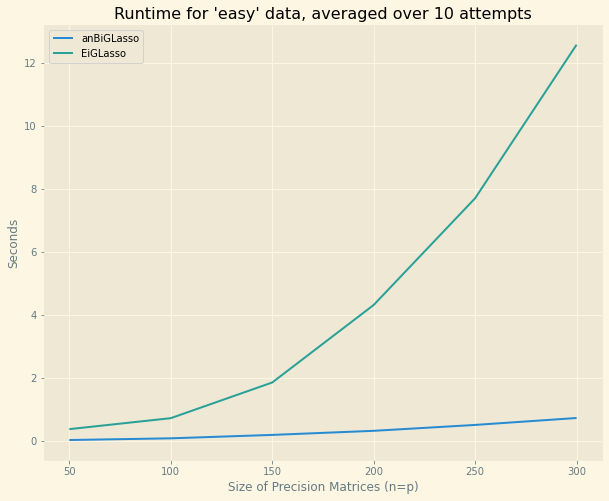

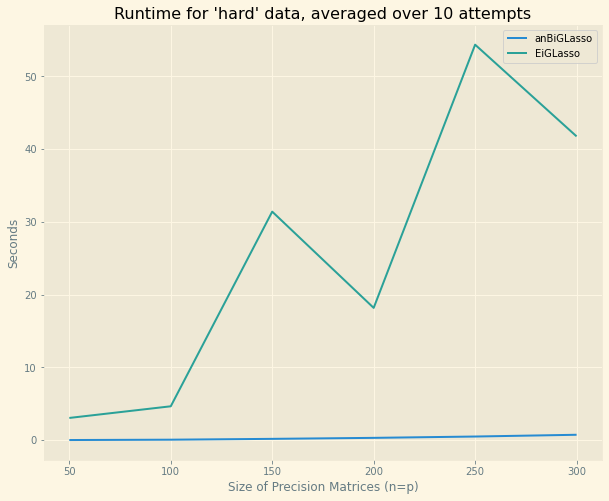

In [10]:
with plt.style.context('Solarize_Light2'):
        fig1, ax1 = plt.subplots(figsize=(10, 8))
        ax1.plot(sizes_for_easy, an_easy, label='anBiGLasso')
        ax1.plot(sizes_for_easy, eig_easy, label='EiGLasso')
        ax1.set_xlabel("Size of Precision Matrices (n=p)")
        ax1.set_ylabel("Seconds")
        ax1.set_title(f"Runtime for 'easy' data, averaged over {attempts} attempts")
        ax1.legend()
        fig1.savefig(f'../../Plots/Runtimes Comparison/Compare Runtimes Easy Data Small Sample No sc')
        fig2, ax2 = plt.subplots(figsize=(10, 8))
        ax2.plot(sizes_for_hard, an_hard, label='anBiGLasso')
        ax2.plot(sizes_for_hard, eig_hard, label='EiGLasso')
        ax2.set_xlabel("Size of Precision Matrices (n=p)")
        ax2.set_ylabel("Seconds")
        ax2.set_title(f"Runtime for 'hard' data, averaged over {attempts} attempts")
        ax2.legend()
        fig2.savefig(f'../../Plots/Runtimes Comparison/Compare Runtimes Hard Data Small Sample No sc')

# Just anBiGLasso, very large data

In [23]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a 'hard' distribution")
sizes_for_hard = [250, 500, 750, 1000, 1250, 1500, 1750, 2000]
an_hard = generate_timing_graph(
    sizes_for_hard,
    attempts,
    df_scale=1,
    m=1,
    verbose=True,
    include_sc=False,
    include_eig=False
)

Times on a 'hard' distribution
Starting size=250
	An: 0.2804696660004993 Seconds
Starting size=500
	An: 1.3158911669997906 Seconds
Starting size=750
	An: 3.8094832499991753 Seconds
Starting size=1000
	An: 8.828317999999854 Seconds
Starting size=1250
	An: 17.37213270800021 Seconds
Starting size=1500
	An: 30.399364583001443 Seconds
Starting size=1750
	An: 49.177293208000265 Seconds
Starting size=2000
	An: 74.89693400000033 Seconds


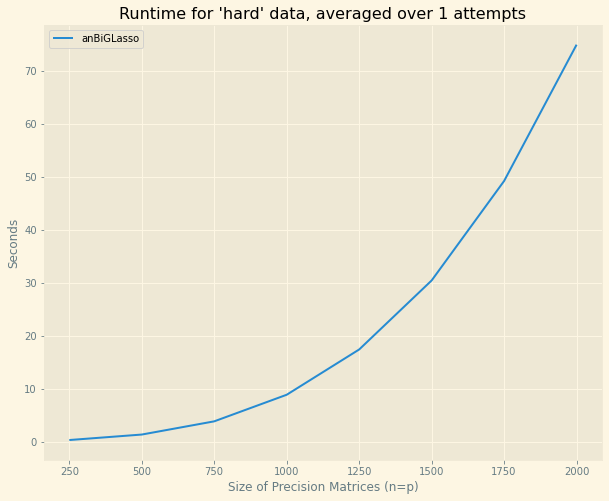

In [24]:
with plt.style.context('Solarize_Light2'):
        fig1, ax1 = plt.subplots(figsize=(10, 8))
        ax1.plot(sizes_for_hard, an_hard, label='anBiGLasso')
        ax1.set_xlabel("Size of Precision Matrices (n=p)")
        ax1.set_ylabel("Seconds")
        ax1.set_title(f"Runtime for 'hard' data, averaged over {attempts} attempts")
        ax1.legend()
        fig1.savefig(
            f'../../Plots/Runtimes Comparison/Compare Runtimes Small Sample Just anBiGLasso'
        )